In [4]:
%matplotlib inline

In [2]:
import tensorflow_probability

In [9]:
#@markdown This sets the warning status (default is `ignore`, since this notebook runs correctly)
warning_status = "default" #@param ["ignore", "always", "module", "once", "default", "error"]
import warnings
warnings.filterwarnings(warning_status)
with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)
    warnings.filterwarnings(warning_status, category=UserWarning)

In [10]:
import os
import numpy as np

matplotlib_style = 'fivethirtyeight'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse

import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize

notebook_screen_res = 'retina'
%config InlineBackend.figure_format = notebook_screen_res

import tensorflow as tf
tfe = tf.contrib.eager

use_tf_eager = False

if use_tf_eager:
    try:
        tf.enable_eager_execution()
    except:
        pass
    
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

In [11]:
def evaluate(tensors):
    """Evaluates Tensor or EagerTensor to Numpy `ndarray`s.
    Args:
    tensors: Object of `Tensor` or EagerTensor`s; can be `list`, `tuple`,
      `namedtuple` or combinations thereof.
 
    Returns:
      ndarrays: Object with same structure as `tensors` except with `Tensor` or
        `EagerTensor`s replaced by Numpy `ndarray`s.
    """
    if tf.executing_eagerly():
        return tf.contrib.framework.nest.pack_sequence_as(
            tensors,
            [t.numpy() if tf.contrib.framework.is_tensor(t) else t
             for t in tf.contrib.framework.nest.flatten(tensors)])
    return sess.run(tensors)

In [12]:
class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

In [13]:
def session_options(enable_gpu_ram_resizing=True, enable_xla=False):
    """
    Allowing the notebook to make use of GPUs if they're available.
    
    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear 
    algebra that optimizes TensorFlow computations.
    """
    config = tf.ConfigProto()
    config.log_device_placement = True
    if enable_gpu_ram_resizing:
        # `allow_growth=True` makes it possible to connect multiple colabs to your
        # GPU. Otherwise the colab malloc's all GPU ram.
        config.gpu_options.allow_growth = True
    if enable_xla:
        # Enable on XLA. https://www.tensorflow.org/performance/xla/.
        config.graph_options.optimizer_options.global_jit_level = (
            tf.OptimizerOptions.ON_1)
    return config

In [14]:
def reset_sess(config=None):
    """
    Convenience function to create the TF graph & session or reset them.
    """
    if config is None:
        config = session_options(enable_gpu_ram_resizing=True, enable_xla=False)
    global sess
    tf.reset_default_graph()
    try:
        sess.close()
    except:
        pass
    sess = tf.InteractiveSession(config=config)

reset_sess()

### Example: Mandatory coin-flip example
Every statistics text must contain a coin-flipping example, I'll use it here to get it out of the way. Suppose, naively, that you are unsure about the probability of heads in a coin flip (spoiler alert: it's 50%). You believe there is some true underlying ratio, call it p, but have no prior opinion on what p might be.

We begin to flip a coin, and record the observations: either H or T. This is our observed data. An interesting question to ask is how our inference changes as we observe more and more data? More specifically, what do our posterior probabilities look like when we have little data, versus when we have lots of data.

Below we plot a sequence of updating posterior probabilities as we observe increasing amounts of data (coin flips), while also demonstrating some of the best practices when it comes to evaluating tensors and plotting the data. First, the easy part: We define the values in our Tensorflow graph

In [15]:
# Build graph
probs_of_heads = tf.linspace(start=0., stop=1., num=100, name='linspace')
n_trials_ = [0, 1, 2, 3, 4, 5, 8, 15, 50, 500, 1000, 2000]

coin_flip_prior = tfp.distributions.Bernoulli(probs=0.5)
coin_flip_data = coin_flip_prior.sample(n_trials_[-1])

n_trials_unpacked = tf.unstack(tf.constant(n_trials_))
counted = [] # this will be the list of processed probability tensors

for k, N in enumerate(n_trials_):
    result_tensor = tf.reduce_sum(coin_flip_data[:N])
    counted.append(result_tensor)

headcounts = tf.stack(counted, 0)

observed_head_probs = [] # this will be the list processed probability tensors
for k, N in enumerate(n_trials_):
    result_tensor = tfp.distributions.Beta(
        concentration1=tf.to_float(1+headcounts[k]),
        concentration0=tf.to_float(1+n_trials_[k] - headcounts[k])).prob(probs_of_heads)
    observed_head_probs.append(result_tensor)
    
observed_probs_heads = tf.stack(observed_head_probs, 0)

Next we move onto executing the graph. We it comes to calculations that need to be made frequently and repeatedly, this method of first-defining and then executing graphs provides a handy speed boost. We can actually use a custom `evaluate()` function that allows us to evaluate tensors whether we are opening in TF Graph mode, or whether we have Eager mode activate. The function looks like the following.

In [16]:
def evaluate(tensors):
    """
    Evaluates Tensor or EagerTensor to Numpy `ndarray`s.
    Args:
    tensors: Object of `Tensor` or EagerTensor`s; can be 'list', 'tuple', 'namedtuple'
        or combinations thereof.
        
    Returns:
        ndarrays: Object with same structure as `tensor` except with `Tensor` or
            `EagerTensor`s replaced by Numpy `ndarray`s.
    """
    if tf.executing_eagerly():
        return tf.contrib.framework.nest.pack_sequence_as(
        tensors,
        [t.numpy() if tf.contrib.framework.is_tensor(t) else t
         for t in tf.contrib.framework.nest.flatten(tensors)])
    return sess.run(tensors)

In [17]:
# Execute graph
[
    n_trials_unpacked_,
    coin_flip_data_,
    probs_of_heads_,
    headcounts_,
    observed_probs_heads_,
] = evaluate([
    n_trials_unpacked,
    coin_flip_data,
    probs_of_heads,
    headcounts,
    observed_probs_heads,
])

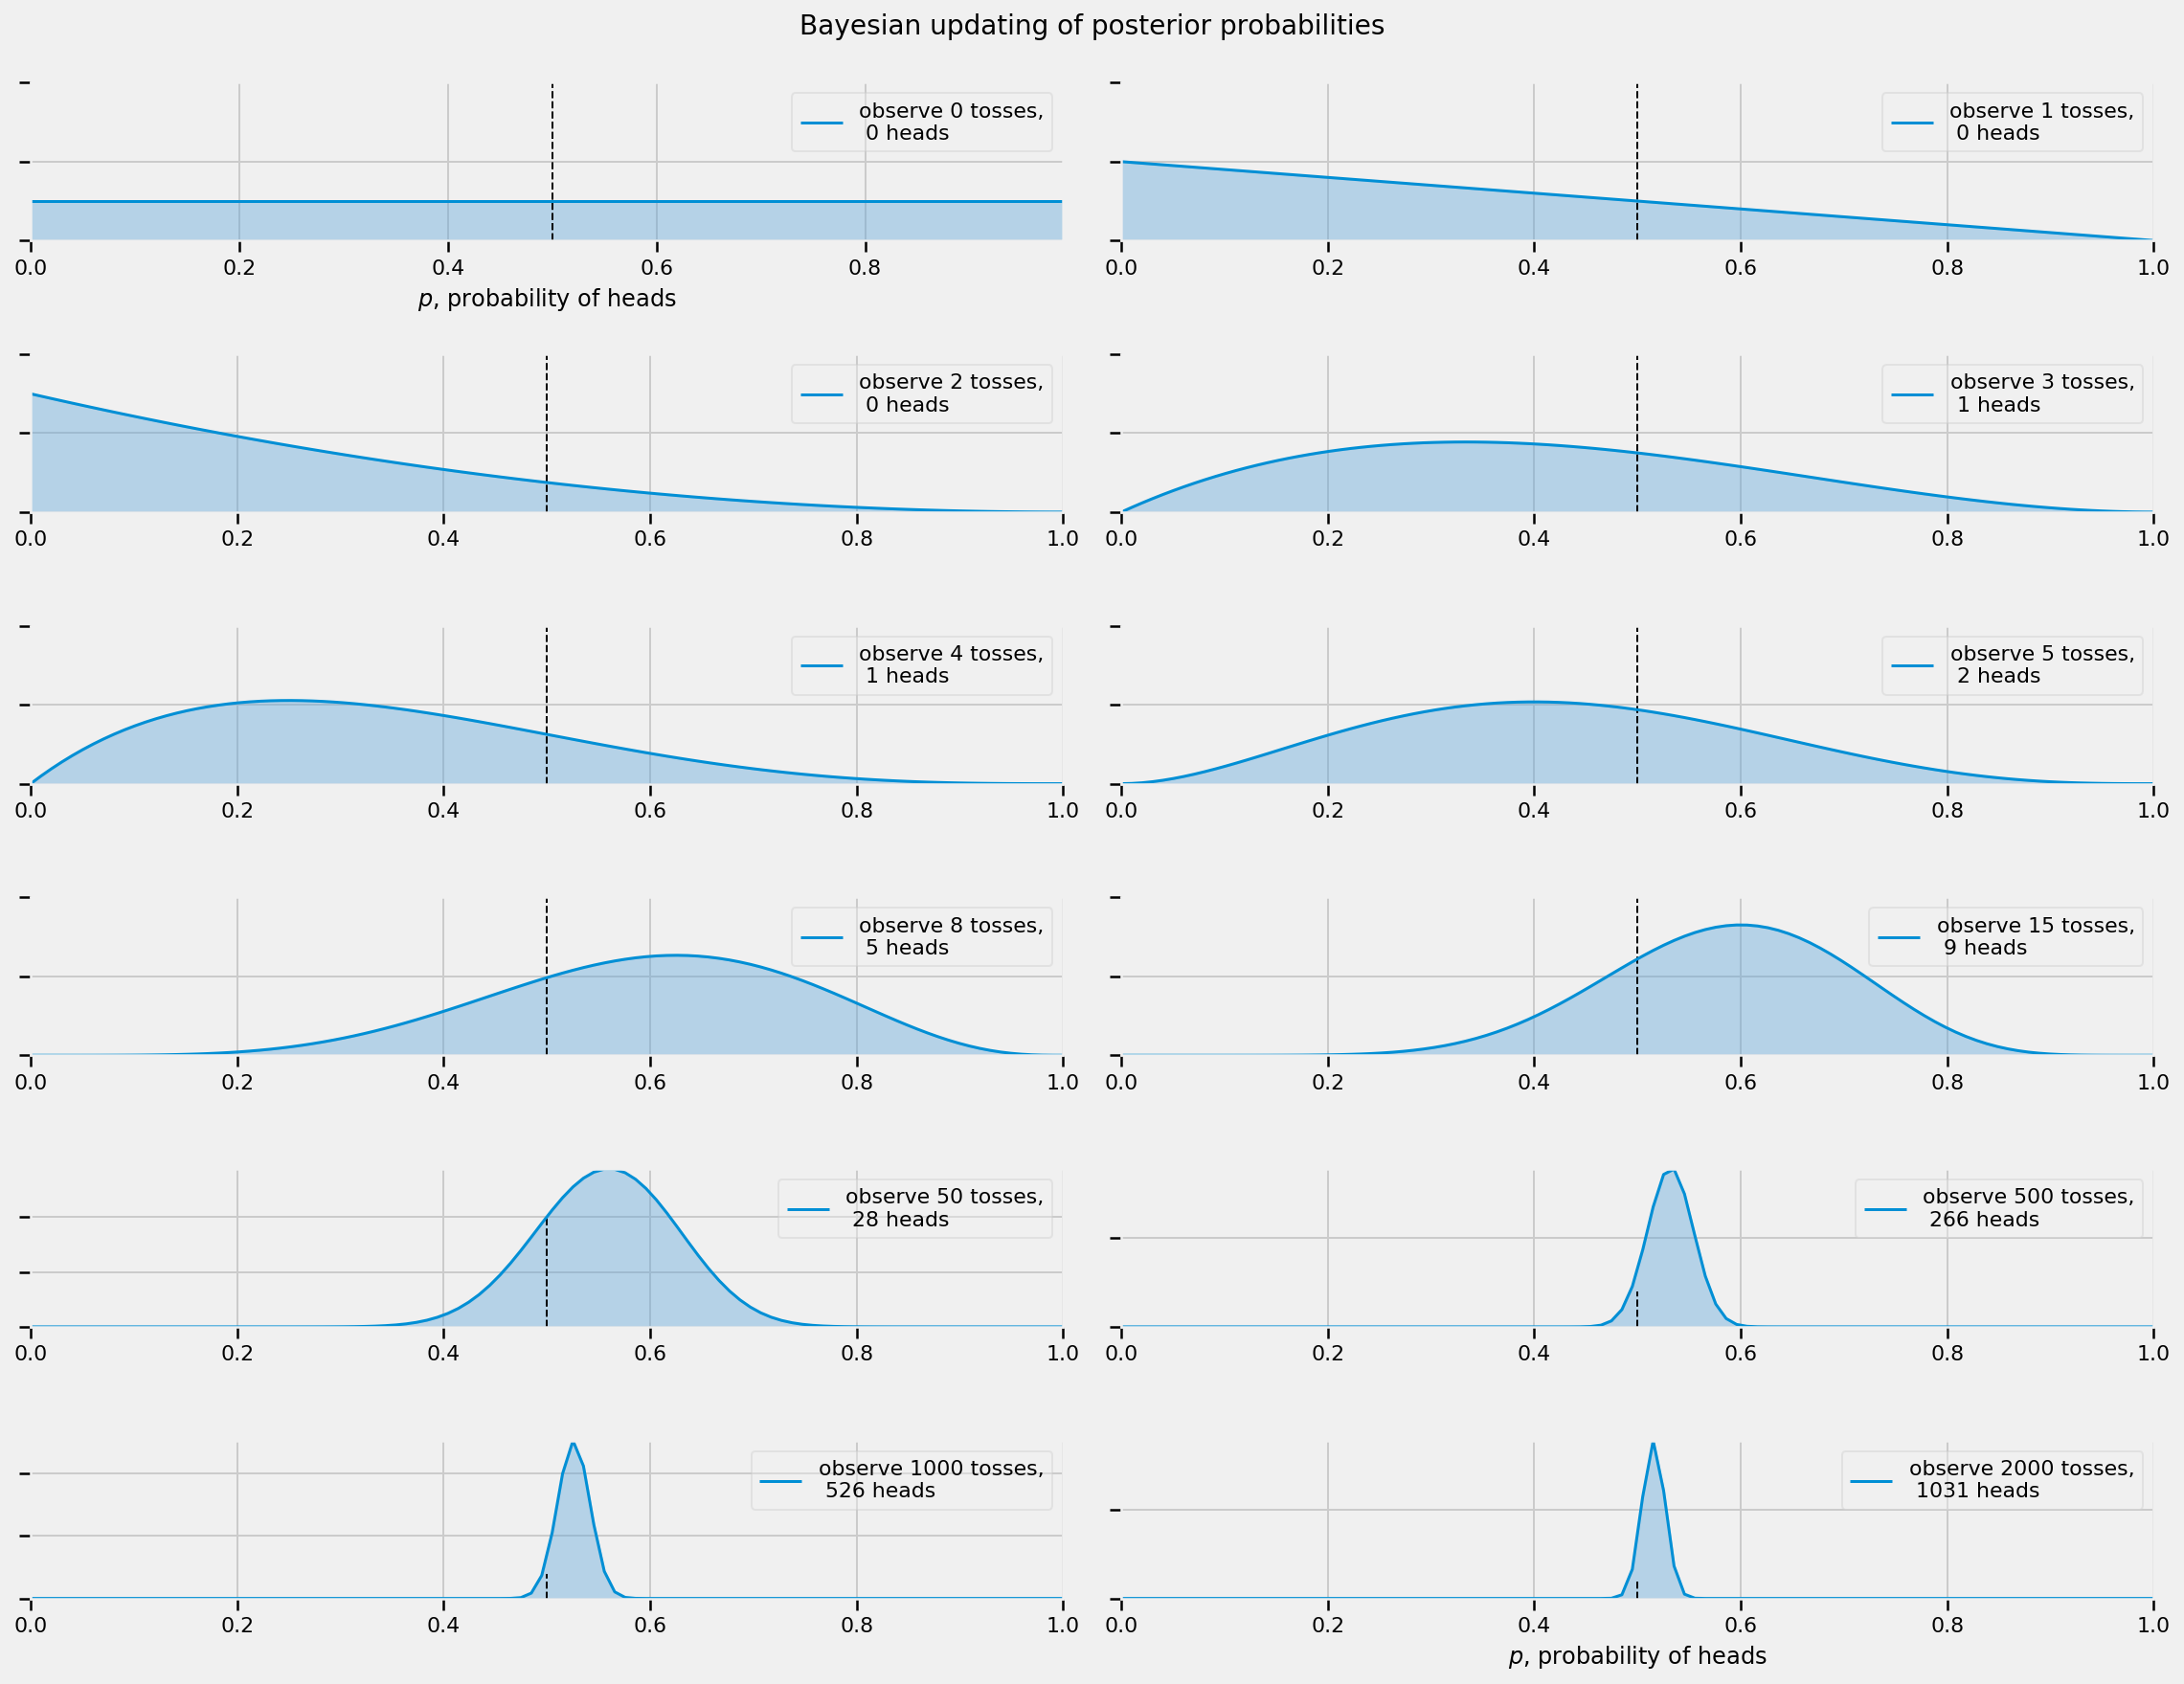

In [18]:
# For the already prepared, I'm using Binomial's conj. prior.

plt.figure(figsize(16, 12))
for i in range(len(n_trials_)):
    sx = plt.subplot(len(n_trials_)/2, 2, i+1)
    plt.xlabel("$p$, probability of heads") \
    if i in [0, len(n_trials_)-1] else None
    plt.setp(sx.get_yticklabels(), visible=False)
    plt.plot(probs_of_heads_, observed_probs_heads_[i], 
             label="observe %d tosses,\n %d heads" % (n_trials_[i], headcounts_[i]))
    plt.fill_between(probs_of_heads_, 0, observed_probs_heads_[i], 
                     color=TFColor[3], alpha=0.4)
    plt.vlines(0.5, 0, 4, color="k", linestyles="--", lw=1)
    leg = plt.legend()
    leg.get_frame().set_alpha(0.4)
    plt.autoscale(tight=True)

plt.suptitle("Bayesian updating of posterior probabilities", y=1.02,
             fontsize=14)
plt.tight_layout()

The posterior probabilities are represented by the curves, and our uncertaintity is proportional to the width of the curve. As the plot above shows, as we start to observe data our posterior probabilities start to shift and move around. Eventually, as we observe more and more data (coin-flips), our probabilities will tighten closer and closer around the true value of $p=0.5$ (marked by a dashed line).

Notice that the plots are not always peaked at 0.5. There is no reason it should be: recall we assumed that we did not have a prior opinion of what p is. In fact, if we observe quite extreme data, say 8 flips and ony 1 observed heads, our distribution would look very biased away from lumping around 0.5. As more data accumulates, we would see more and more probability being assigned at $p=0.5$, though never all of it.

## Bug or not
Let $A$ denote the event that our code has no bug in it. Let $X$ denote the event that the code passes all debugging tests. For now, we will leave the prior probability of no bugs as a variable, i.e. $P(A) = p$.

We are interested in $P(A|X)$, i.e. the probability of no bugs, given our debugging tests $X$. To use the formula above, we need to compute some quantities.

What is $P(A|X)$, i.e. the probability that the code passes $X$ tests given there are no bugs? Well, it is equal to 1, for a code with no bugs will pass all tests.

$P(X)$ is a little bit tricker: The event $X$ can be divided into two possibilities, event $X$ occurring even though our code indeed has bugs (denoted by $\sim A$, spoken not $A$), or event $X$ without bugs ($A$). $P(X)$ can be represented as:
\begin{eqnarray}
P(A|X) & = & \frac{P(X|A)P(A)}{P(X)}\\
P(X) & = & P(X\,\mathrm{and}\,A) + P(X\,\mathrm{and}\,\sim A)\\
& = & P(X|A)P(A) + P(X|\sim A)P(\sim A) \\
& = & P(X|A)p + P(X|\sim A)(1-p)
\end{eqnarray}

We have already computed $P(X|A)$ above. On the other hand, $P(X|\sim A)$ is subjective: our code can pass tests but still have a bug in it, though the probability there is a bug present is reduced. Note this is dependent on the number of tests performed, the degree of complication in the tests, etc. Let's be conservative and assign $P(X|\sim A) = 0.5$. Then:
\begin{eqnarray}
P(A|X) & = & \frac{1\cdot p}{1\cdot p + 0.5(1-p)} \\
& = & \frac{2p}{1+p}
\end{eqnarray}
This is the posterior probability. What does it look like as a function of our prior, $p\in[0, 1]$?

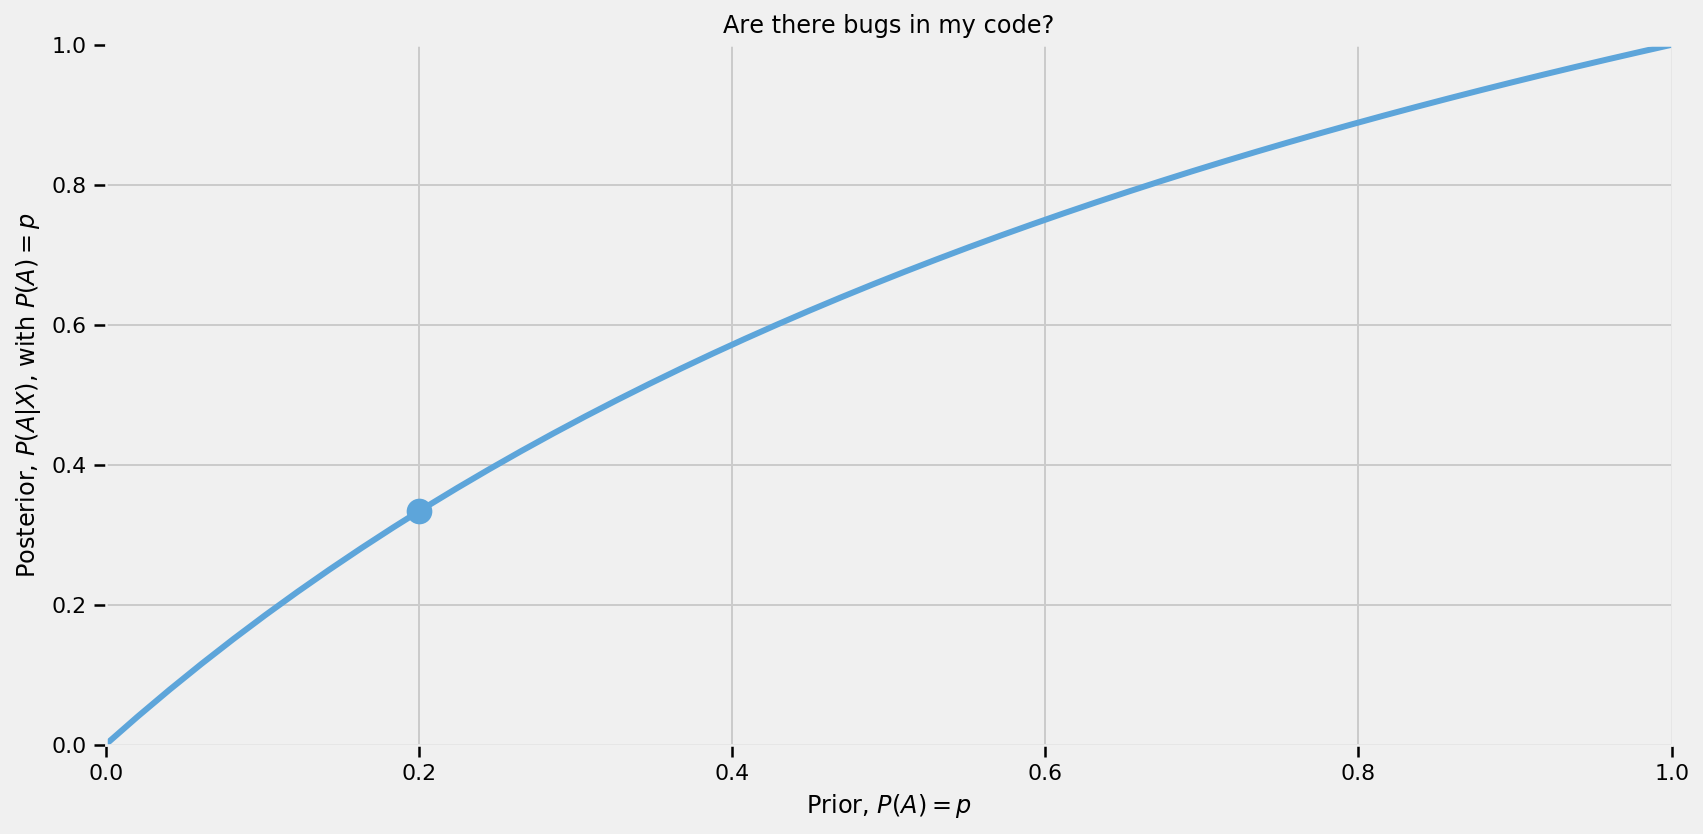

In [19]:
# Defining our range of probabilities
p = tf.linspace(start=0., stop=1., num=50)

# convert from TF to numpy
[p_] = evaluate([p])

# visualization
plt.figure(figsize=(12.5, 6))
plt.plot(p_, 2*p_/(1+p_), color=TFColor[3], lw=3)
plt.scatter(0.2, 2*(0.2)/1.2, s=140, c=TFColor[3])
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel(r"Prior, $P(A) = p$")
plt.ylabel(r"Posterior, $P(A|X)$, with $P(A) = p$")
plt.title(r"Are there bugs in my code?");

We can see the biggest gains if we observe the $X$ tests passed when the prior probability, $p$, is low. Let's settle on a specific value for the prior. I'm a stronger programmer (I think), so I'm going to give myself a realistic prior of 0.20, that is, there is a 20% chance that I write bug-free code. To be more realistic, this prior should be a function of how complicated and large the code is, but let's pin it at 0.2. Then my updated belief that my code is bug-free is 0.33.

Recall that the prior is a probability: $p$ is the prior probability that there are no bugs, so $1-p$ is the prior probability that there are bugs.

Similarly, our posterior is also a probability, with $P(A|X)$ the probability there is no bug given we saw all tests pass, hence $1-P(A|X)$ is the probability there is a bug given all tests passed. What does our posterior probability look like? 

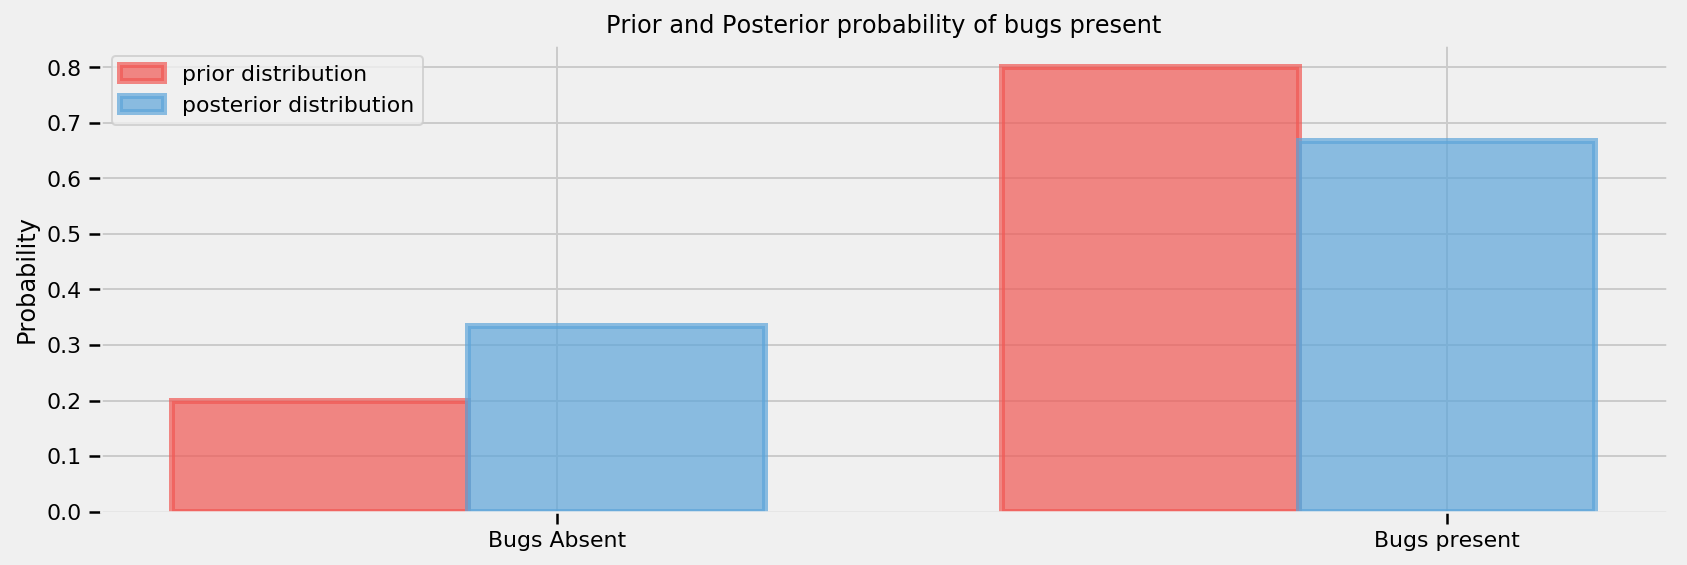

In [21]:
# Defining our priors and posteriors
prior = tf.constant([0.20, 0.80])
posterior = tf.constant([1./3, 2./3])

# Convert from TF to numpy.
[
    prior_,
    posterior_,
] = evaluate([
    prior,
    posterior,
])

# Our simple visualization
plt.figure(figsize=(12.5, 4))
colours = [TFColor[0], TFColor[3]]
plt.bar([0, .7], prior_, alpha=0.70, width=0.25,
       color=colours[0], label='prior distribution',
       lw='3', edgecolor=colours[0])
plt.bar([0+0.25, .7+0.25], posterior_, alpha=0.7,
       width=0.25, color=colours[1],
       label=r"posterior distribution",
       lw="3", edgecolor=colours[1])

plt.xticks([0.20, 0.95], ["Bugs Absent", "Bugs present"])
plt.title(r"Prior and Posterior probability of bugs present")
plt.ylabel('Probability')
plt.legend(loc='upper left')

Notices that after we observed $X$ occur, the probability of bugs being absent increased. By increasing the number of tests, we can approach confidence (probability 1) that there are no bugs present.

### Probability Distributions
Probability Distribution: Let $Z$ be some random variable. Then associated with $Z$ is a probability distribution function that assigns probabilities to the different outcomes $Z$ can take. Graphically, a probability distribution is a curve where the probability of an outcome is proportional to the height of the curve.

We can divide random variables into three classifications:
* $Z$ is discrete: Discrete random variables may only assume values on a specified list. Things like populations, movie ratings, and number of votes are all discrete random variables. 
* $Z$ is continuous: Continuous random variable can take on arbitrarily exact values. For example, temperature, speed, time, color
* $Z$ is mixed: Mixed random variables assign probabilities to both discrete and continuous random variables.

### Build Poisson graph
We say $Z$ is *Poisson*-distributed if 
$$
P(Z=k) = \frac{\lambda^k\mathrm{e}^{-\lambda}}{k!}\,\,\, k = 0, 1, 2, 3\ldots
$$
$\lambda$ is called a parameter of the distribution, and it controls the distribution's shape. For the Poisson distribution, $\lambda$ can be any positive number. By increasing $\lambda$, we add more probability to larger values, and conversely by decreasing $\lambda$ we add more probability to larger values, and conversely by decreasing $\lambda$ we add more probability to smaller values. One can describe $\lambda$ as the *intensity* of the Poisson distribution.

Unlike $\lambda$, which can be any positive number, the value $k$ in the above formula must be a non-negative integer, i.e. $k$ must take on values 0, 1, 2 and so on. This is very important, because if you want to model a population you could not make sense of populations with 4.25 or 5.612 members.

If a random variable $Z$ has a Poisson mass distribution, we denote this by writing
$$
Z\sim \mathrm{Poi}(\lambda)
$$
One useful property of the Poisson distribution is that its expected value is equal to its parameter, i.e.
$$
E[Z|\lambda] = \lambda
$$
We plot the probability mass distribution for different $\lambda$ values. The first thing to notice is that by increasing $\lambda$, we add more probability of larger values occurring. Second, notice that although the graph ends at 15, the distributions do not. They assign positive probability to every non-negative integer.

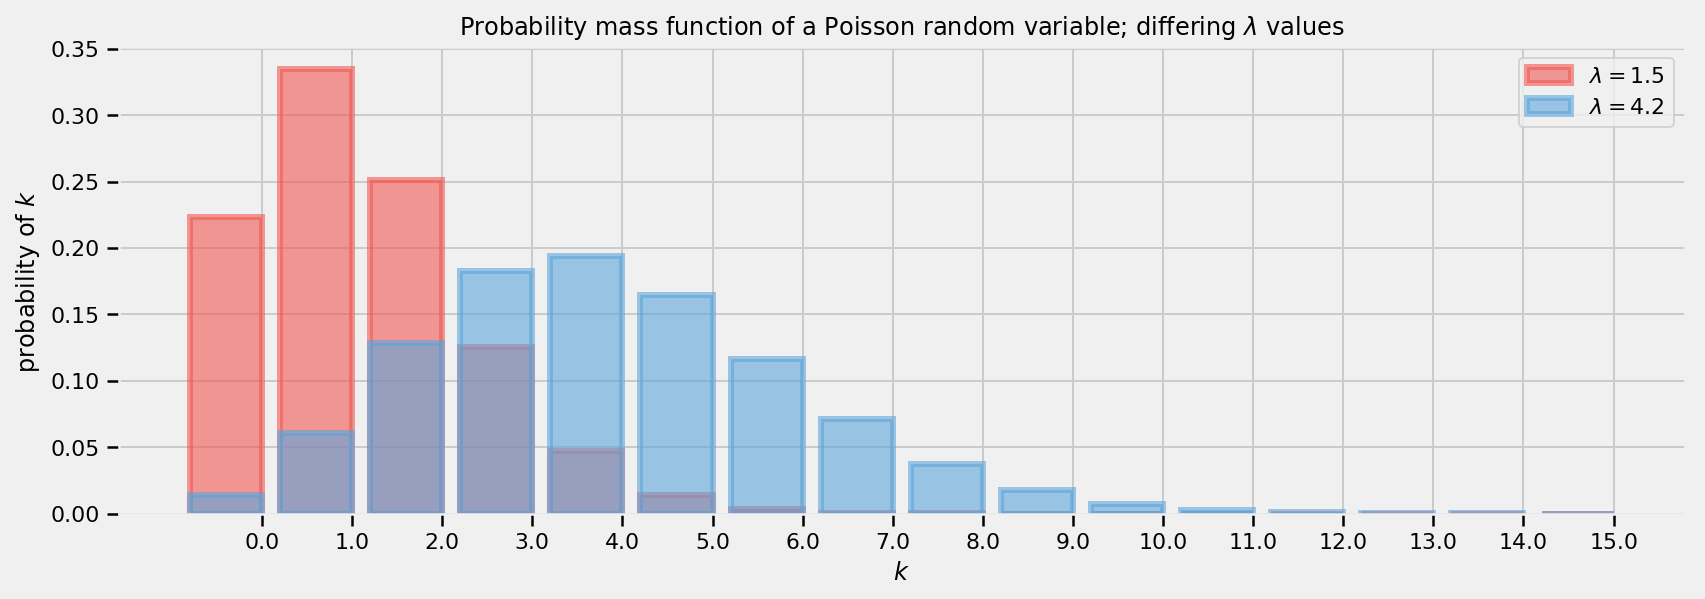

In [22]:
# Build graph.
grid_of_days = tf.range(start=0, limit=16.)
texts_per_day = tf.constant([1.5, 4.25])
text_count_probs = tfp.distributions.Poisson(
    rate=texts_per_day[:, tf.newaxis]).prob(grid_of_days)

# Execute graph
[
    grid_of_days_,
    texts_per_day_,
    text_count_probs_,
] = evaluate([
    grid_of_days,
    texts_per_day,
    text_count_probs,
])

# Display results
plt.figure(figsize=(12.5, 4))
colours = [TFColor[0], TFColor[3]]
plt.bar(grid_of_days_,
        text_count_probs_[0],
        color=colours[0],
        label=r"$\lambda = %.1f$" % texts_per_day_[0], alpha=0.60,
        edgecolor=colours[0], lw="3")

plt.bar(grid_of_days_,
        text_count_probs_[1],
        color=colours[1],
        label=r"$\lambda = %.1f$" % texts_per_day_[1], alpha=0.60,
        edgecolor=colours[1], lw="3")

plt.xticks(grid_of_days_ + 0.4, grid_of_days_)
plt.legend()
plt.ylabel(r"probability of $k$")
plt.xlabel(r"$k$")
plt.title(r"Probability mass function of a Poisson random variable; differing $\lambda$ values");

### Continuous Case

Instead of a probability mass function, a continuous random variable has a *probability density function*. This might seem like unnecessary nomenclature, but the density function and the mass function are very different creatures. An example of continuous random variable is a random variable with *exponential density*. The density function for an exponential random variable looks like this:

$$
f_Z(z|\lambda) = \lambda\mathrm{e}^{-\lambda z},\,\, z\ge 0
$$

Like a Poisson random variable, an exponential random variable can take on only non-negative values. Unlike a Poisson variable, the exponential can take on *any* non-negative values, including non-integral values. This property makes it a poor choice for count data, which must be an integer, but a great choice for time data, temperature data (measured in Kelvins) or any other precise and *positive* variable. The graph below shows two probability density function with different $\lambda$ values.

When a random variable $Z$ has an exponential distribution with parameter $\lambda$, we say $Z$ is *exponential* and write

$$
Z\sim \mathrm{Exp}(\lambda)
$$

Given a specific $\lambda$, the expected value of an exponential random variable is equal to the inverse of $\lambda$, that is:

$$
E[Z|\lambda] = \frac{1}{\lambda}
$$

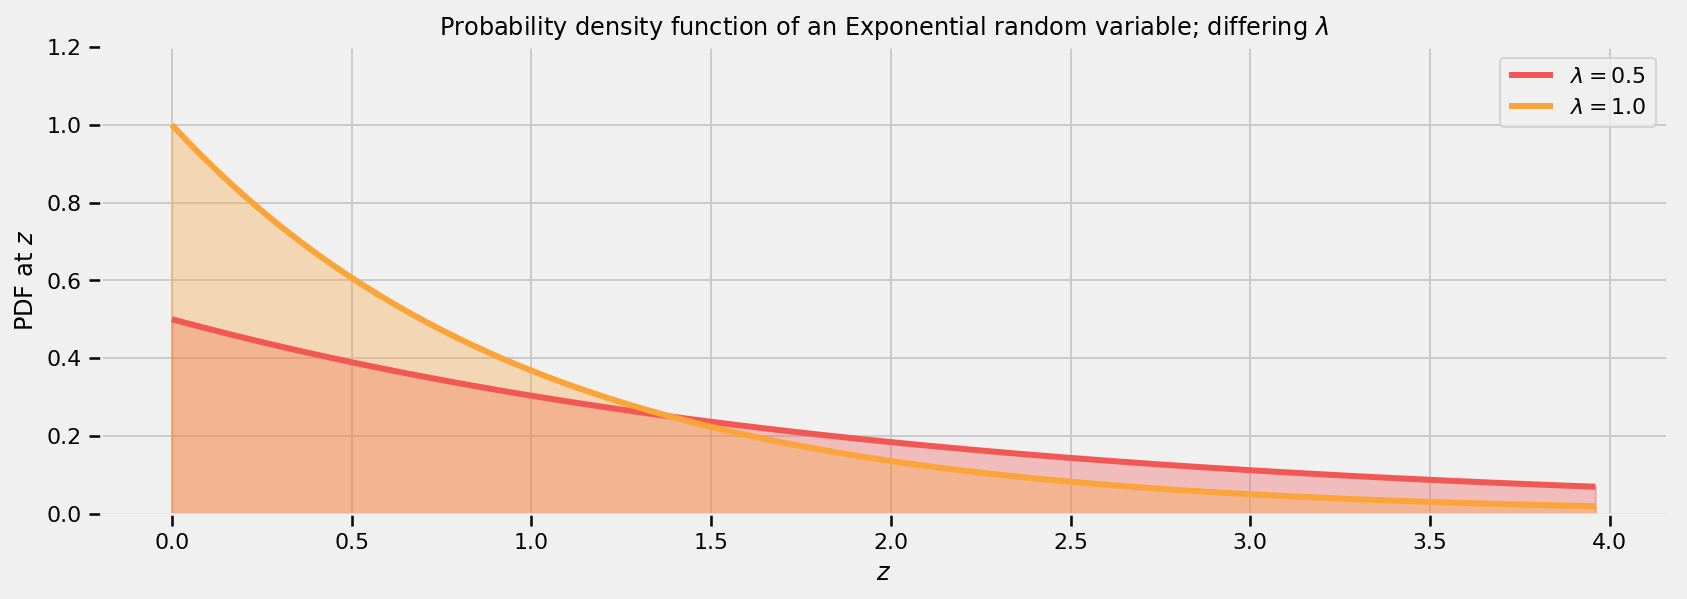

In [23]:
# Defining our Data and assumptions (use tf.linspace for continuous)
a = tf.range(start=0., limit=4., delta=0.04)
a = a[..., tf.newaxis]
lambdas = tf.constant([0.5, 1.])

# Now we use TFP to compute probabilities in a vectorized manner.
pdf_at_z = tfp.distributions.Exponential(rate=lambdas).prob(a)

# Convert from TF to numpy
[
    a_,
    lambdas_,
    pdf_at_z_,
] = evaluate([
    a,
    lambdas,
    pdf_at_z,
])

# Visualizing our results
plt.figure(figsize=(12.5, 4))
for i in range(lambdas_.size):
    plt.plot(a_.T[0], pdf_at_z_.T[[i]][0],
             lw=3, color=TFColor[i], label=r"$\lambda = %.1f$" % lambdas_[i])
    plt.fill_between(a_.T[0], pdf_at_z_.T[[i]][0],
                         color=TFColor[i], alpha=.33)
plt.legend()
plt.ylabel("PDF at $z$")
plt.xlabel("$z$")
plt.ylim(0,1.2)
plt.title(r"Probability density function of an Exponential random variable; differing $\lambda$");

### But what is $\lambda$?

This question is what motivates statistics. In the real world, $\lambda$ is hidden from us. We see only $Z$, and must go backwards to try and determine $\lambda$. The problem is difficult because there is no one-to-one mapping from $Z$ to $\lambda$. Many different methods have been created to solve the problem of estimating $\lambda$, but since $\lambda$ is never actually observed, no one can say for certain which method is best!

Bayesian inference is concerned with *beliefs* about what $\lambda$ might be. Rather than try to guess $\lambda$ exactly, we can only talk about what $\lambda$ is likely to be by assigning a probability distribution to $\lambda$.

This might seem odd at first. After all, $\lambda$ is fixed; it is not (necessarily) random! How can we assign probabilities to values of a non-random variable? Recall that under Bayesian philosophy, we can assign probabilities if we interpret them as beliefs, and it is entirely acceptable to have *belief* about the parameter $\lambda$.

### Example: Inferring behaviour from text-message data
Let's try to model a more interesting example, one that concerns the rate at which a user sends and receives text messages:
> You are given a series of daily text-message counts from a user of your system. You are curious to know if the user's text-messaging habits have changed over time, either gradually or suddenly. How can you model this?

Count Data Mean:  19.743244


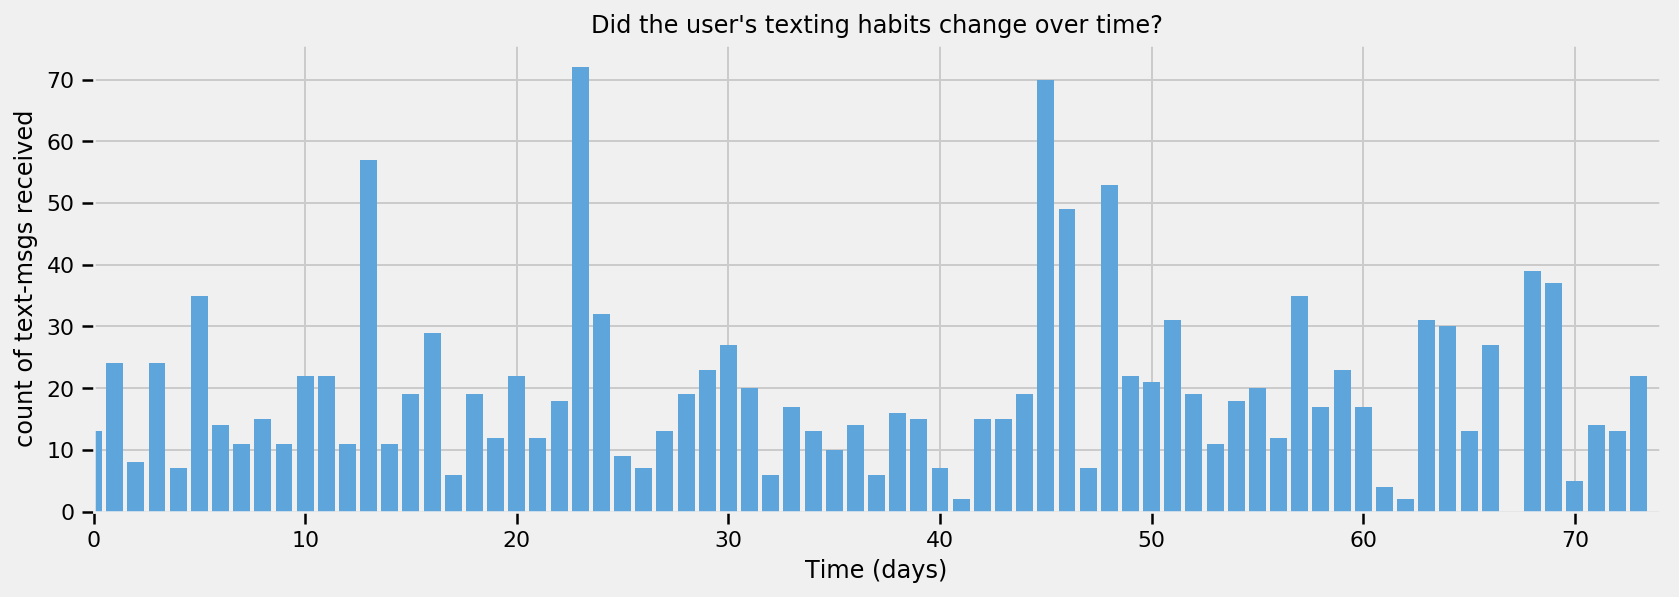

In [24]:
count_data = tf.constant([
    13,  24,   8,  24,   7,  35,  14,  11,  15,  11,  22,  22,  11,  57,  
    11,  19,  29,   6,  19,  12,  22,  12,  18,  72,  32,   9,   7,  13,  
    19,  23,  27,  20,   6,  17,  13,  10,  14,   6,  16,  15,   7,   2,  
    15,  15,  19,  70,  49,   7,  53,  22,  21,  31,  19,  11,  18,  20,  
    12,  35,  17,  23,  17,   4,   2,  31,  30,  13,  27,   0,  39,  37,   
    5,  14,  13,  22,
], dtype=tf.float32)
count_data_mean = tf.reduce_mean(count_data)
n_count_data = tf.shape(count_data)
count_of_text_msgs = tf.range(n_count_data[0])

# Convert from TF to numpy.
[
    count_data_, 
    count_data_mean_,
    n_count_data_, 
    count_of_text_msgs_,
] = evaluate([
    count_data, 
    count_data_mean,
    n_count_data,
    count_of_text_msgs,
])

# Visualizing the Results
plt.figure(figsize=(12.5, 4))
plt.bar(count_of_text_msgs_, count_data_, color="#5DA5DA")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data_[0]);

print("Count Data Mean: ", count_data_mean_)

How can we start to model this? Well, a Poisson random variable is a very appropriate model for this type of *count* data. Denoting day *i*'s text-message count by $C_i$.

$$
C_i\sim \mathrm{Poisson}(\lambda)
$$

We are not sure what the value of the $\lambda$ parameter really is, however. Looking at the chart above, it appears that the rate might become higher late in the observation period, which is equivalent to saying that $\lambda$ increases at some point during the observations. (Recall that a higher value of $\lambda$ assigns more probability to larger outcomes. That is, there is a higher probability of many text messages having been sent on a given day.)

How can we represent this observation mathematically? Let's assume that on some day during the observation period (call it $\tau$), the parameter $\lambda$ suddenly jumps to a higher value. So we really have two $\lambda$ parameters: one for the period before $\tau$, and one for the rest of the observation period. In the literature, a sudden transition like this would be called a *switchpoint*:

$$\lambda = 
\begin{cases} \lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}
$$

If, in reality, no sudden change occurred and indeed $\lambda_1 = \lambda_2$, then the $\lambda$'s posterior distributions should look about equal.

We are interested in inferring the unknown $\lambda$s. To use Bayesian inference, we need to assign prior probabilities to the different possible values of $\lambda$. What would be good prior probability distributions for $\lambda_1$ and $\lambda_2$? Recall that $\lambda$ can be any positive number. As we saw earlier, the *exponential* distribution provides a continuous density function for positive numbers, so it might be a good choice for modelling $\lambda_i$. But recall that the exponential distribution takes a parameter of its own, so we'll need to include that parameter in our model. Let's call that parameter $\alpha$.

\begin{eqnarray}
\lambda_1 &\sim& \mathrm{Exp}(\alpha)\\
\lambda_2 &\sim& \mathrm{Exp}(\alpha)
\end{eqnarray}

$\alpha$ is called a *hyper-parameter* or *parent variable*. In literal terms, it is a parameter that influences other parameters. Our initial guess at $\lambda$ does not influence the model too strongly, so we have some flexibility in our choice. A good rule of thumb is to set the exponential parameter equal to the inverse of the average of the count data. Since we are modelling $\lambda$ using an exponential distribution, we can use the expected value identity shown earlier to get:

$$
\frac{1}{N}\sum_{i=0}^N C_i\approx E[\lambda|\alpha] = \frac{1}{\alpha}
$$

An alternative, would be have two priors: one for each $\lambda_i$. Creating two exponential distributions with different $\alpha$ values reflects our prior belief that the rate changed at some point during the observations.

What about $\tau$? Because of the noisiness of the data, it is difficult to pick out apriori where $\tau$ might have occurred. Instead, we can assign a *uniform prior belief* to every possible day. This is equivalent to saying

$$
\tau\sim\mathrm{DiscreteUniform}(1, 70)\\
\rightarrow P(\tau = k) = \frac{1}{70}
$$

So after all this, what does our overall prior distribution for the unknown variables look like? Frankly *it doesn't matter*. What we should understand is that it's an ugly, complicated mess involving symbols only a mathematicians could love. And things will only get uglier the more complicated our models become. Regardless, all we really care about is the posterior distribution.

### Introducing our first hammer: TensorFlow Probability
TensorFlow Probability (TFP) is a Python library for programming Bayesian analysis. It is intended for data scientists, statisticians, machine learning practitioners, and scientists. Since it is built on the TensorFlow (TF) stack, it brings the runtime benefits of TF to Bayesian analysis. These include write-once run-many (ability to run your development model in production) and speedups via state-of-the-art hardware (GPUs and TPUs).

Since TFP is relatively new, the TFP community is actively developing documentation, especially docs and examples that bridge the gap between beginner and hacker. One of this book's main goals is to solve that problem, and also to demonstrate why TFP is so cool.

We will model the problem above using TFP. This type of programming is called probabilistic programming, an unfortunate misnomer that invokes ideas of randomly-generated code and has likely confused and frightened users away from this field. The code is not random; it is probabilistic in the sense that we create probability models using programming variables as the model's components.

B. Cronin [4] has a very motivating description of probabilistic programming:

>Another way of thinking about this: unlike a traditional program, which only runs in the forward directions, a probabilistic program is run in both the forward and backward direction. It runs forward to compute the consequences of the assumptions it contains about the world (i.e., the model space it represents), but it also runs backward from the data to constrain the possible explanations. In practice, many probabilistic programming systems will cleverly interleave these forward and backward operations to efficiently home in on the best explanations.

Because of the confusion engendered by the term *probabilistic programming*, I'll refrain from using it. Instead, I'll simply say programming, since that's what it really is.

TFP code is easy to read. The only novel thing should be the syntax. Simply remember that we are representing the model's components ($\tau, \lambda_1, \lambda_2$ ) as variables.

### Specify the joint log-density
We'll assume the data is a consequence of the following generative model:

$$\begin{align*}
\lambda_{1}^{(0)} \sim \text{Exponential}(\text{rate}=\alpha) \\
\lambda_{2}^{(0)} \sim \text{Exponential}(\text{rate}=\alpha) \\
\tau \sim \text{Uniform}[\text{low}=0,\text{high}=1) \\
\text{for }  i =  1\ldots N: \\
\lambda_i = \begin{cases} \lambda_{1}^{(0)}, \tau > i/N \\ \lambda_{2}^{(0)}, \text{otherwise}\end{cases}\\
 X_i \sim \text{Poisson}(\text{rate}=\lambda_i)
\end{align*}$$
Happily, this model can be easily implemented using TF and TFP's distributions:

This code creates a new function `lambda_`, but really we can think of it as a random variable: the random variable $\lambda$ from above. The gather function assigns `lambda_1` or `lambda_2` as the value of `lambda_`, depending on what side of `tau` we are on. The values of `lambda_` up until `tau` are `lambda_1` and the values afterwards are `lambda_2`.

Note that because `lambda_1`, `lambda_2` and `tau` are random, `lambda_` will be random. We are **not** fixing any variables yet.

In [25]:
def joint_log_prob(count_data, lambda_1, lambda_2, tau):
    tfd = tfp.distributions
    
    alpha = np.array(1./count_data.mean(), np.float32)
    
    rv_lambda_1 = tfd.Exponential(rate=alpha)
    rv_lambda_2 = tfd.Exponential(rate=alpha)
    
    rv_tau = tfd.Uniform()
    
    lambda_ = tf.gather(
        [lambda_1, lambda_2],
        indices=tf.to_int32(tau * count_data.size <= np.arange(count_data.size)))
    rv_observation = tfd.Poisson(rate=lambda_)
    
    return (
        rv_lambda_1.log_prob(lambda_1) +
        rv_lambda_2.log_prob(lambda_2) +
        rv_tau.log_prob(tau) + 
        tf.reduce_sum(rv_observation.log_prob(count_data)))

Notice that the implementation is arguably very close to being a 1:1 translation of the mathematical model. The main difference is that once we've specified the probabilistic model, we return the sum of the log_probs.

### Specify the posterior sampler
One can think of this as a *learning step*. The machinery being employed is called *Markov Chain Monte Carlo (MCMC)*. This technique returns thousands of random variables from the posterior distributions of $\lambda_1, \lambda_2$ and $\tau$. We can plot histograms of the random variables to see what the posterior distributions look like.

In [26]:
# Set the chain's start date
initial_chain_state = [
    tf.to_float(tf.reduce_mean(count_data)) * tf.ones([], dtype=tf.float32, name='init_lambda1'),
    tf.to_float(tf.reduce_mean(count_data)) * tf.ones([], dtype=tf.float32, name='init_lambda2'),
    0.5 * tf.ones([], dtype=tf.float32, name='init_tau')
]

# Since HMC operates over unconstrained space, we need to transform the 
# samples to they live in real-space
unconstraining_bijectors = [
    tfp.bijectors.Exp(), # Maps a positive real to R.
    tfp.bijectors.Exp(), # Maps a positive real to R.
    tfp.bijectors.Sigmoid(), # Maps [0, 1] to R.
]

def joint_log_prob(count_data, lambda_1, lambda_2, tau):
    tfd = tfp.distributions
    
    alpha = (1./ tf.reduce_mean(count_data))
    rv_lambda_1 = tfd.Exponential(rate=alpha)
    rv_lambda_2 = tfd.Exponential(rate=alpha)
    
    rv_tau = tfd.Uniform()
    
    lambda_ = tf.gather(
    [
        lambda_1, lambda_2
    ], indices=tf.to_int32(tau * tf.to_float(tf.size(count_data)) <= tf.to_float(tf.range(tf.size(count_data)))))
    rv_observation = tfd.Poisson(rate=lambda_)
    
    return (
        rv_lambda_1.log_prob(lambda_1)
        + rv_lambda_2.log_prob(lambda_2)
        + rv_tau.log_prob(tau)
        + tf.reduce_sum(rv_observation.log_prob(count_data))
        )

In [27]:
# Define a closure over our joint_log_prob
def unnormalized_log_posterior(lambda1, lambda2, tau):
    return joint_log_prob(count_data, lambda1, lambda2, tau)

In [28]:
# Initialize the step_size. (It will be automatically adapted.)
with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE):
    step_size = tf.get_variable(
        name='step_size',
        initializer=tf.constant(0.05, dtype=tf.float32),
        trainable=False,
        use_resource=True
    )

In [29]:
# Sample from the chain
[
    lambda_1_samples,
    lambda_2_samples,
    posterior_tau,
], kernel_results = tfp.mcmc.sample_chain(
    num_results=100000,
    num_burnin_steps=10000,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=unnormalized_log_posterior,
            num_leapfrog_steps=2,
            step_size=step_size,
            step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(),
            state_gradients_are_stopped=True
        ), bijector=unconstraining_bijectors))

In [30]:
tau_samples = tf.floor(posterior_tau * tf.to_float(tf.size(count_data)))

# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tf.shape(tau_samples)[0]
expected_texts_per_day = tf.zeros(n_count_data)

# Initialize any created variables
init_g = tf.global_variables_initializer()
init_l = tf.local_variables_initializer()